## **TASK 07: DOCUMENT CLUSTERING WITH Doc2Vec**

### Using 'combined_dataset.csv'

Word Embeddings

In [1]:
# Importing necessary libraries

import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [4]:
# Loading the dataset

df = pd.read_csv('/content/combined_dataset.csv')

# Preparing the data for Doc2Vec

documents = [TaggedDocument(words=eval(tokens), tags=[str(i)]) for i, tokens in enumerate(df['Tokens'])]

In [7]:
# Initializing and training the Doc2Vec model

doc2vec_model = Doc2Vec(vector_size=100, min_count=2, epochs=20, workers=4)
doc2vec_model.build_vocab(documents)  # This will build the vocabulary
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Saving the model

doc2vec_model.save("doc2vec_model.model")
print("Doc2Vec model has been saved.")

Doc2Vec model has been saved.


In [16]:
# Generating embeddings for each document

df['Embeddings'] = df['Tokens'].apply(lambda tokens: doc2vec_model.infer_vector(eval(tokens)))

# Saving the updated dataset with embeddings

df.to_csv('combined_dataset_with_embeddings.csv', index=False)

print(df[['Tokens', 'Embeddings']].head())

print(f"Embeddings have been generated and saved")

                                              Tokens  \
0  ['fabio', 'quartararo', 'said', 'impressed', '...   
1  ['author', 'article', 'article', 'content', 'b...   
2  ['rashid', 'vally', 'visionary', 'behind', 'so...   
3  ['ollirichard', 'smith', 'chairliololliuk', 'h...   
4  ['caracol', '’', 'acclaimed', 'series', 'el', ...   

                                          Embeddings  
0  [-0.027102964, 0.05581381, 0.033751413, -0.009...  
1  [-0.034272037, 0.041716952, 0.043946978, -0.01...  
2  [-0.046731357, 0.06869225, 0.0545946, -0.00988...  
3  [-0.029262781, 0.039319772, 0.03271239, -0.004...  
4  [-0.03959509, 0.06489835, 0.056157794, -0.0134...  
Embeddings have been generated and saved


Determinig Optimal K value

In [17]:
# Importing necessary libraries

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [19]:
# Converting embeddings column to a list of vectors

embeddings = list(df['Embeddings'])

# Determining optimal k using the Elbow Method

wcss = []  # Within-Cluster Sum of Squares
silhouette_scores = []  # Silhouette Scores

k_values = range(2, 11)  # Testing k from 2 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

    # Calculating the Silhouette Score

    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

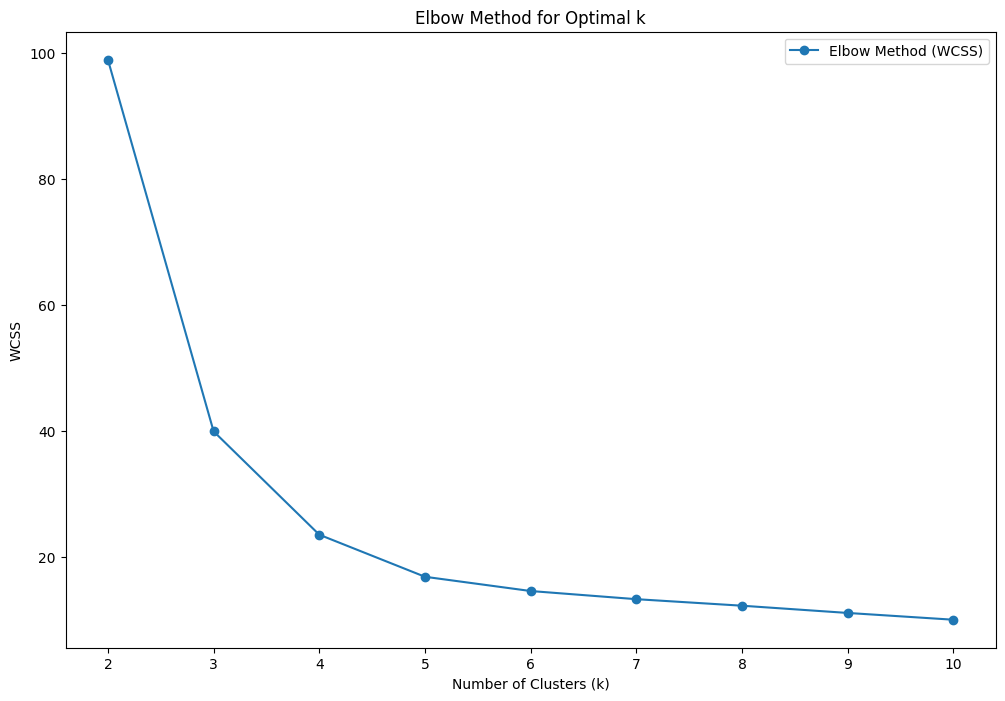

In [21]:
# Plotting the Elbow Method

plt.figure(figsize=(12, 8))
plt.plot(k_values, wcss, marker='o', label='Elbow Method (WCSS)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.show()

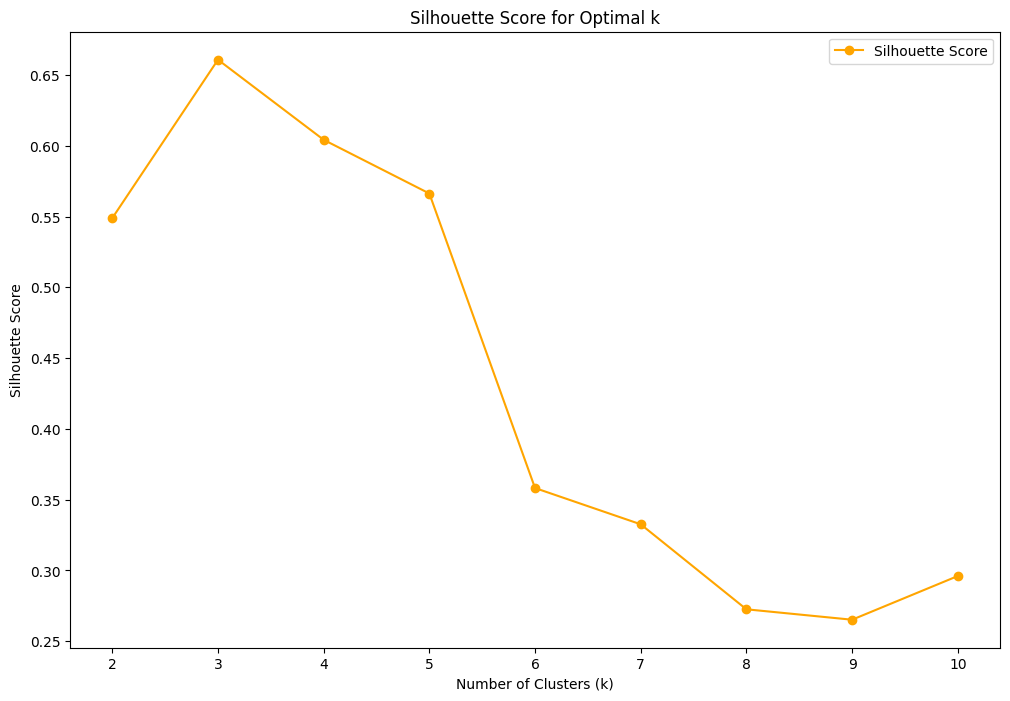

In [22]:
# Plotting the Silhouette Scores

plt.figure(figsize=(12, 8))
plt.plot(k_values, silhouette_scores, marker='o', color='orange', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.legend()
plt.show()

In [23]:
# Setting the chosen k as 3
# Based on Silhouette Score and Elbow Method analysis done above, 3 is the optimal k value because Silhouette Score prioritizes cluster cohesion and seperation
# This maximizes the clustering quality than the Elbow Method whicih had a k value of 4, prioritizing interpretability and balance

chosen_k = 3

# Performing K-Means Clustering

kmeans = KMeans(n_clusters=chosen_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(embeddings)

# Displaying the first few rows with clusters

print(df[['Tokens', 'Cluster']].head())

# Displaying the number of documents in each cluster

print("Cluster distribution:\n", df['Cluster'].value_counts())

# Saving the clustered dataset

df.to_csv('clustered_documents.csv', index=False)
print("Clustered dataset has been saved.")


                                              Tokens  Cluster
0  ['fabio', 'quartararo', 'said', 'impressed', '...        0
1  ['author', 'article', 'article', 'content', 'b...        0
2  ['rashid', 'vally', 'visionary', 'behind', 'so...        1
3  ['ollirichard', 'smith', 'chairliololliuk', 'h...        0
4  ['caracol', '’', 'acclaimed', 'series', 'el', ...        1
Cluster distribution:
 Cluster
0    351
1     71
2     30
Name: count, dtype: int64
Clustered dataset has been saved.


Dimensionality Reductions Using PCA

In [24]:
# Importing necessary libraries

from sklearn.decomposition import PCA

In [26]:
# Applying PCA to reduce dimensions to a moderate level

pca = PCA(n_components=50)
pca_result = pca.fit_transform(list(df['Embeddings']))

print(f"PCA reduced dimensions shape: {pca_result.shape}")

PCA reduced dimensions shape: (452, 50)


In [29]:
cluster_names = {0: "Cluster A", 1: "Cluster B", 2: "Cluster C"}

  Visualization Using t-SNE

In [35]:
# Importing necessary libraries

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


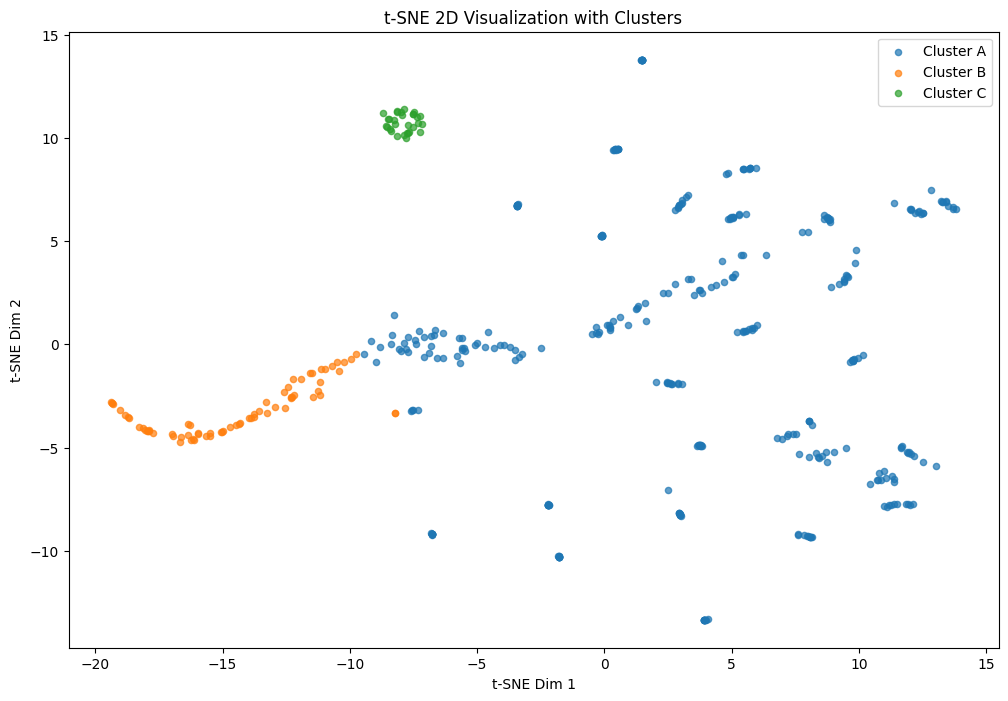

In [37]:
# Applying t-SNE to reduce to 2D

tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_2d_result = tsne_2d.fit_transform(pca_result)

# Plotting the 2D visualization

plt.figure(figsize=(12, 8))
for cluster in sorted(df['Cluster'].unique()):
    idx = df['Cluster'] == cluster
    plt.scatter(tsne_2d_result[idx, 0], tsne_2d_result[idx, 1], s=20, alpha=0.7, label=cluster_names[cluster])

plt.title("t-SNE 2D Visualization with Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


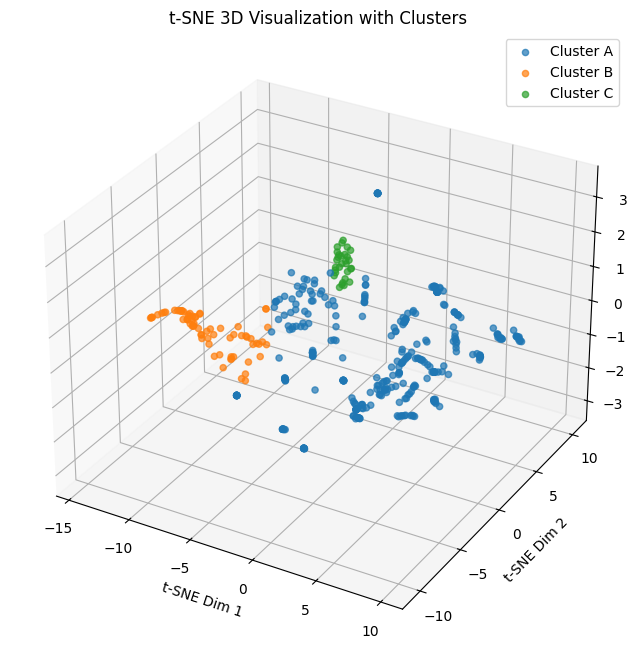

In [40]:
# Applying t-SNE to reduce to 3D

tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
tsne_3d_result = tsne_3d.fit_transform(pca_result)

# Plotting the 3D visualization

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster, name in cluster_names.items():
    idx = df['Cluster'] == cluster
    ax.scatter(tsne_3d_result[idx, 0], tsne_3d_result[idx, 1], tsne_3d_result[idx, 2],
               s=20, alpha=0.7, label=name)

ax.set_title("t-SNE 3D Visualization with Clusters")
ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_zlabel("t-SNE Dim 3")
ax.legend()
plt.show()

Analysing Cluster Transition Patterns

In [47]:
# Importing necessary libraries

from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx

In [48]:
# Calculating cluster centroids

cluster_centroids = df.groupby('Cluster')['Embeddings'].apply(lambda x: x.mean(axis=0))

# Computing pairwise distances between centroids

centroid_distances = euclidean_distances(list(cluster_centroids))
print("Pairwise Cluster Distances:")
print(centroid_distances)

Pairwise Cluster Distances:
[[0.        1.0668144 1.4613577]
 [1.0668144 0.        1.4581114]
 [1.4613577 1.4581114 0.       ]]


In [50]:
# Cross-tabulation of Sentiment vs Cluster

sentiment_transition = pd.crosstab(df['Cluster'], df['Sentiment'])
print("Sentiment Distribution Across Clusters:\n")
print(sentiment_transition)

# Normalizing to understand sentiment percentages in each cluster

sentiment_transition_percentage = sentiment_transition.div(sentiment_transition.sum(axis=1), axis=0)
print("Sentiment Percentage Distribution Across Clusters:\n")
print(sentiment_transition_percentage)

Sentiment Distribution Across Clusters:

Sentiment  negative  neutral  positive
Cluster                               
0                67      141       143
1                 6       21        44
2                 0        0        30
Sentiment Percentage Distribution Across Clusters:

Sentiment  negative   neutral  positive
Cluster                                
0          0.190883  0.401709  0.407407
1          0.084507  0.295775  0.619718
2          0.000000  0.000000  1.000000


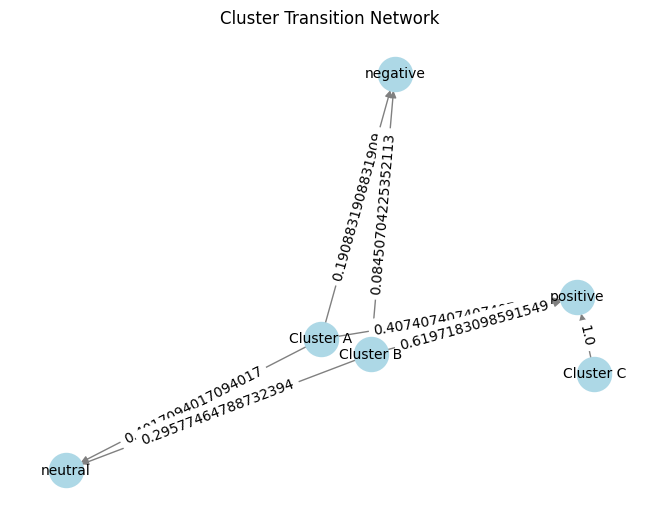

In [64]:
# Creating a graph to visualize transitions

G = nx.DiGraph()

# Adding nodes for clusters

for cluster, name in cluster_names.items():
    G.add_node(name)

# Adding weighted edges based on transition probabilities

for cluster, row in sentiment_transition_percentage.iterrows():
    for sentiment, weight in row.items():
        if weight > 0.05:  # Including significant transitions
            G.add_edge(cluster_names[cluster], sentiment, weight=weight)

# Drawing the graph

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=600, font_size=10, node_color='lightblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Cluster Transition Network")
plt.show()